# This notebook combines small parcels into bigger parcels depending on the Euclidean distance between them. In our setting we use 50 meters. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PARCELS = "/content/gdrive/My Drive/Colab Notebooks/CS506FinalProject/final_parcels_coords.csv"

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import json

import folium
from folium import plugins
from folium.plugins import HeatMap

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
parcels_origin = pd.read_csv(PARCELS)
parcels_origin.head(20)

,Unnamed: 0,ADDRESSEE,CITY,FULL_ADDRESS,MAIL_ADDRESS,MAIL_CS,MAIL_ZIPCODE,OWNER,Unnamed: 0.1,Unnamed: 0.1.1,ZIPCODE,address_on_map,lat,lon
0,0,VIPOND ALEX RICHARD,EAST BOSTON,"288 LEXINGTON ST, 02128",288 LEXINGTON ST,EAST BOSTON MA,02128,VIPOND ALEX RICHARD,0,0,2128.0,"288 lexington st, east boston, 02128",42.380572,-71.030120
1,1,ALFARO MAREL W,EAST BOSTON,"335 E EAGLE ST, 02128",335 E EAGLE ST,EAST BOSTON MA,02128,ALFARO MAREL W,1,1,2128.0,"335 e eagle st, east boston, 02128",42.381250,-71.027780
2,2,GAVEGNANO HENRY J,EAST BOSTON,"BREMEN ST, 02128",TWO JERICHO PZ WING C STE 11,JERICHO NY,11753,GAVEGNANO HENRY J,2,2,2128.0,"bremen st, east boston, 02128",42.374128,-71.032806
3,3,MASSACHUSETTS PORT AUTHORITY,EAST BOSTON,"5 VIENNA ST, 02128",1 HARBORSIDE DR #200S,EAST BOSTON MA,02128,MASSACHUSETTS PORT AUTHORITY,3,3,2128.0,"5 vienna st, east boston, 02128",42.379767,-71.024596
4,4,MASS WATER RESOURCE AUTHORTY,EAST BOSTON,"CHELSEA ST, 02128",CHELSEA,EAST BOSTON MA,02128,MASS WATER RESOURCE AUTHORTY,4,4,2128.0,"chelsea st, east boston, 02128",42.371344,-71.037101
5,5,FIVE46 SARATOGA STREET LLC,EAST BOSTON,"546 SARATOGA ST, 02128",581 BOYLSTON ST STE 604,BOSTON MA,02116,FIVE46 SARATOGA STREET LLC,5,5,2128.0,"546 saratoga st, east boston, 02128",42.380942,-71.025119
6,6,TETZAGUIC HILDA,EAST BOSTON,"668 BENNINGTON ST, 02128",668 BENNINGTON ST,E BOSTON MA,02128,TETZAGUIC HILDA,6,6,2128.0,"668 bennington st, east boston, 02128",42.375361,-71.037625
7,7,DA SILVA EDIVALDO BENTO,EAST BOSTON,"1084 SARATOGA ST, 02128",1084 SARATOGA,EAST BOSTON MA,02128,DA SILVA EDIVALDO BENTO,7,7,2128.0,"1084 saratoga st, east boston, 02128",42.380303,-71.026454
8,8,TOSCANO VINCENT A,EAST BOSTON,"1078 SARATOGA ST, 02128",1078 SARATOGA ST,EAST BOSTON MA,02128,TOSCANO VINCENT A,8,8,2128.0,"1078 saratoga st, east boston, 02128",42.380303,-71.026454
9,9,LOPEZ JOHN M ETAL,EAST BOSTON,"1072 SARATOGA ST, 02128",1072 SARATOGA,EAST BOSTON MA,02128,LOPEZ JOHN M ETAL,9,9,2128.0,"1072 saratoga st, east boston, 02128",42.380303,-71.026454


In [ ]:
print(parcels_origin.shape)

(170731, 14)


#Some helper functions:

In [ ]:
def is_city_Boston(zipcode):
  """zipcode: an integer number which is the zipcode"""
  """return true if it is within city of Boston; false otherwise"""
  zip = [2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 
         2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2163,
         2196, 2199, 2201, 2203, 2204, 2205, 2206, 2210, 2211, 2212, 2215, 2217, 2222, 2241, 2266, 
         2283, 2284, 2293, 2297, 2298]
  try:
    if int(zipcode) in zip:
      return 1
    else:
      return 0
  except:
    return 0

def whole_address(full, city, zip):
  """" returns the whole address of a parcel """
  return (full[:-5] + city + ',0' + str(int(zip))).lower()

def is_within(lat1, lon1, lat2, lon2):
  """ whether 2 parcels are within certain distance """
  if abs(lat1 - lat2) <= n_meter_lat and abs(lon1 - lon2) <= n_meter_lon:
    return True
  return False

def get_avg_lat_lon(lats, lons):
  """ get the average latitudes and longitudes from 2 lists """
  lat_avg = sum(lats) / len(lats)
  lon_avg = sum(lons) / len(lons)
  return lat_avg, lon_avg

def generateBaseMap(default_location =[42.361145, -71.057083]):
  base_map = folium.Map( location=default_location)
  return base_map

def show_on_map(name, df, c):
  """ show the clusterings on map and save as html"""
  """ name: the html file name, a string"""
  """ df: the pandas dataframe"""
  """ c: the color"""
  base_map = generateBaseMap()
  df.apply(lambda row: folium.CircleMarker(location=[row["lat"], row["lon"]], radius=5, color=c).add_to(base_map), axis=1)
  base_map.save(name)

The average latitudes of our parcels.

In [ ]:
avg_lat = parcels_origin['lat'].mean()
print(avg_lat)

42.23833374839008


#Convert meters and longitudes & latitudes. Math here.

In [ ]:
one_meter_on_lat = 1 / 111320
one_meter_on_lon = one_meter_on_lat / math.cos(42.3 * 0.018)
print("1 m in lat: "+str(one_meter_on_lat))
print("1 m in lon: "+str(one_meter_on_lon))
lat_lon_ratio = one_meter_on_lat / one_meter_on_lon
print(lat_lon_ratio)

n_meter_lat = 50 * one_meter_on_lat
n_meter_lon = 50 * one_meter_on_lon
print('%f' % n_meter_lat)
print(n_meter_lon)

1 m in lat: 8.98311174991017e-06
1 m in lon: 1.240982730233615e-05
0.7238708106936427
0.000449
0.0006204913651168075


#Drop those addresses that are not in Boston area. 

In [ ]:
parcels_origin = parcels_origin[parcels_origin['ZIPCODE'].map(lambda x: is_city_Boston(x)) == 1]
parcels_origin = parcels_origin.dropna()
print(parcels_origin.shape)

# remove wrong entries that are clearly not within MA
parcels_origin = parcels_origin[parcels_origin['lat'] < 42.4]
parcels_origin = parcels_origin[parcels_origin['lat'] > 42.2]
parcels_origin = parcels_origin[parcels_origin['lon'] < -70.9]
parcels_origin = parcels_origin[parcels_origin['lon'] > -71.5]
print(parcels_origin.shape)

unique_lats = set(parcels_origin['lat'].to_list())
print(len(unique_lats))


#parcels_origin['valid_address'] = parcels_origin.apply(lambda row: whole_address(row['FULL_ADDRESS'], row['CITY'], row['ZIPCODE']), axis = 1)
#parcels = parcels_origin.drop(columns=['Unnamed: 0', 'CITY', 'OWNER', 'FULL_ADDRESS', 'ZIPCODE', 'MAIL_ADDRESS', 'ADDRESSEE', 'MAIL_CS', 'MAIL_ZIPCODE', 'address_on_map'])
parcels = parcels_origin[['lat', 'lon', 'address_on_map']]

parcels = parcels.groupby(['lat', 'lon']).agg(lambda x: tuple(x)).applymap(list).reset_index()
#parcels = parcels.groupby(["lat", "lon"])['valid_address'].apply(list)
parcels.head(10)

(170731, 14)
(169015, 14)
86703


,lat,lon,address_on_map
0,42.232105,-71.129619,"[54 meadowview rd, hyde park, 02136]"
1,42.232159,-71.128829,"[meadow rd, hyde park, 02136]"
2,42.232215,-71.130024,"[53 meadowview rd, hyde park, 02136]"
3,42.232262,-71.129549,"[50 meadowview rd, hyde park, 02136]"
4,42.232404,-71.130497,"[66 colchester st, hyde park, 02136]"
5,42.232417,-71.129926,"[49 meadowview rd, hyde park, 02136]"
6,42.232423,-71.131005,"[65 colchester st, hyde park, 02136]"
7,42.232457,-71.129462,"[46 meadowview rd, hyde park, 02136]"
8,42.232551,-71.130443,"[62 colchester st, hyde park, 02136]"
9,42.232553,-71.129876,"[45 meadowview rd, hyde park, 02136]"


#Combine the parcels.
The result is a dictionary, containing the average longitudes, latitudes and all the small parcels that are included in one bigger parcel.

In [ ]:
combined_dict = {}
sparse_dict = parcels.to_dict('index')
print(len(sparse_dict.keys()))
print(sparse_dict[0])

index2 = 0
lats = [] # list of lats 
lons = [] # list of lons
addresses = [] # lists of addresses of parcels that are in the combination
current_lat = None # the "center"
current_lon = None # the "center"
is_included = [0 for i in range(len(sparse_dict.keys()))] # if the current small parcel is included in any combination

# something like a greedy algorithm: combine all the parcels that all within n meter square; one parcel can only be in 1 cluster
for i in range(len(sparse_dict.keys())):
  if is_included[i] == 1: # it has been a part of a bigger parcel
    continue
  else: # initialize
    instance = sparse_dict[i]
    lat = instance['lat']
    lon = instance['lon']
    address = instance['address_on_map']
    lats.append(lat)
    lons.append(lon)
    addresses += address
    current_lat = lat
    current_lon = lon
    is_included[i] = 1 # update the record
    for j in range(i+1, len(sparse_dict.keys())):
      if is_included[j] == 1:
        continue
      else:
        instance = sparse_dict[j]
        lat = instance['lat']
        lon = instance['lon']
        address = instance['address_on_map']
        if is_within(current_lat, current_lon, lat, lon):
          lats.append(lat)
          lons.append(lon)
          addresses += address
          is_included[j] = 1

  # update the info of bigger parcels
  lat_avg, lon_avg = get_avg_lat_lon(lats, lons)
  inner = {'lat': lat_avg, 'lon': lon_avg, 'addresses': addresses}
  combined_dict[index2] = inner
  index2 += 1
  lats = [] 
  lons = [] 
  addresses = []

print(len(combined_dict.keys()))

87640
{'lat': 42.2321047, 'lon': -71.1296193176282, 'address_on_map': ['54   meadowview rd, hyde park, 02136']}
13121


Transform the dictionary to a dataframe.

In [ ]:
combined_parcels = pd.DataFrame.from_dict(combined_dict, orient='index')
combined_parcels.head(20)

,lat,lon,addresses
0,42.232335,-71.129743,"[54 meadowview rd, hyde park, 02136, 53 meadowview rd, hyde park, 02136, 50 meadowview rd, hyde park, 02136, 49 meadowview rd, hyde park, 02136, 46 meadowview rd, hyde park, 02136, 45 meadowview rd, hyde park, 02136]"
1,42.232159,-71.128829,"[meadow rd, hyde park, 02136]"
2,42.232633,-71.130628,"[66 colchester st, hyde park, 02136, 65 colchester st, hyde park, 02136, 62 colchester st, hyde park, 02136, 58 colchester st, hyde park, 02136, 61 colchester st, hyde park, 02136, 71 millstone rd, hyde park, 02136, 63 colchester st, hyde park, 02136]"
3,42.232842,-71.129517,"[42 meadowview rd, hyde park, 02136, 75 millstone rd, hyde park, 02136, meadowview rd, hyde park, 02136, 38 meadowview rd, hyde park, 02136, 72 millstone rd, hyde park, 02136, 37 meadowview rd, hyde park, 02136, 34 meadowview rd, hyde park, 02136]"
4,42.232839,-71.132042,"[65 clifford st, hyde park, 02136, 80 hamilton st, hyde park, 02136, 70 clifford st, hyde park, 02136, 61 clifford st, hyde park, 02136]"
5,42.232967,-71.131394,"[64 clifford st, hyde park, 02136, 58 clifford st, hyde park, 02136, 67 millstone rd, hyde park, 02136, 63 millstone rd, hyde park, 02136, 59 millstone rd, hyde park, 02136]"
6,42.233131,-71.132806,"[81 hamilton st, hyde park, 02136, 79 hamilton st, hyde park, 02136, 76 hamilton st, hyde park, 02136, 77 hamilton st, hyde park, 02136, 73 hamilton st, hyde park, 02136]"
7,42.233261,-71.130077,"[70 millstone rd, hyde park, 02136, 56 colchester st, hyde park, 02136, 55 colchester st, hyde park, 02136, 33 meadowview rd, hyde park, 02136, 54 colchester st, hyde park, 02136, 29 meadowview rd, hyde park, 02136, 51 colchester st, hyde park, 02136, 25 meadowview rd, hyde park, 02136, 50 colchester st, hyde park, 02136, 52 colchester st, hyde park, 02136]"
8,42.233430,-71.130827,"[64 millstone rd, hyde park, 02136, 50 clifford st, hyde park, 02136, 48 clifford st, hyde park, 02136, 53 colchester st, hyde park, 02136, 48 colchester st, hyde park, 02136, 46 clifford st, hyde park, 02136]"
9,42.233389,-71.129130,"[30 meadowview rd, hyde park, 02136, 26 meadowview rd, hyde park, 02136, 22 meadowview rd, hyde park, 02136, 21 meadowview rd, hyde park, 02136]"


#Visualize all the big parcels.

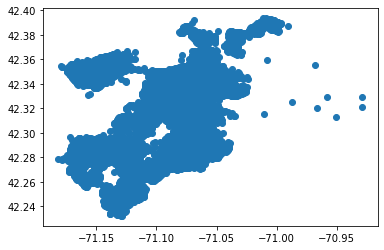

In [ ]:
current_lats = combined_parcels['lat'].to_list()
current_lons = combined_parcels['lon'].to_list()
plt.scatter(current_lons, current_lats)
plt.show()

show_on_map("/content/gdrive/My Drive/Colab Notebooks/data/show_parcels_temp.html", combined_parcels, 'red')

In [ ]:
print(combined_parcels.shape)

(13121, 3)


#Now, let's load the dataset of essential services and match each big parcel with n cloest essential services of each kind.
n = 2 in our setting.

In [ ]:
combined_parcels.to_csv("/content/gdrive/My Drive/Colab Notebooks/CS506FinalProject/CS506_combined_parcels.csv")

In [ ]:
all_essential_services = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/CS506FinalProject/merged_processed5.csv")
all_essential_services = all_essential_services.drop(columns=['Unnamed: 0'])
print(all_essential_services.shape)
all_essential_services.head()

(5620, 6)


,name,type,address,zip,lat,lon
0,7-Eleven,grocery,462 Washington St,2135.0,42.348527,-71.158960
1,24 Seven,grocery,655 Warren St,2121.0,42.309813,-71.082883
2,24 Seven Convenience Store,grocery,655 Warren St,2121.0,42.309813,-71.082883
3,Food Land,grocery,199 Adams St,2122.0,42.302039,-71.060150
4,660 Corp,grocery,543 Commonwealth Ave,2215.0,42.349045,-71.097122


In [ ]:
all_types = set(all_essential_services['type'].to_list())
print(all_types)

{'healthcare', 'park', 'open space', 'hospital', 'supermarket', 'grocery'}


Divide.

In [ ]:
supermarkets = all_essential_services[all_essential_services['type'] == 'supermarket'].to_dict('index')
parks_openspace = all_essential_services[all_essential_services['type'].isin(['park', 'open space'])].to_dict('index')
grocery = all_essential_services[all_essential_services['type'] == 'grocery'].to_dict('index')
healthcares = all_essential_services[all_essential_services['type'] == 'healthcare'].to_dict('index')
hospitals = all_essential_services[all_essential_services['type'] == 'hospital'].to_dict('index')

In [ ]:
# look at the ids of one essential service
supermarkets.keys()

dict_keys([1330, 1343, 1347, 1350, 1382, 1383, 1402, 1417, 1546, 1573, 1803, 2134, 2136, 2148, 2308, 2510, 2533, 2570, 2585, 2695, 2737, 2777, 2795, 2879, 2967, 2981, 3073, 3129, 3222, 3386, 3419, 3442, 3445, 3459, 3480, 3489, 3498, 3563, 3635, 3664, 3669, 3812, 3920, 3955, 4038, 4072, 4102, 4109, 4137, 4198, 4203, 4250, 4260, 4309, 4319, 4322, 4452, 4548, 4607, 4614, 4673, 4681, 4691, 4803, 4901, 4941, 4948, 4951])

# Time for matching

In [ ]:
def get_match_dict(combined_dict, service_dict):
  """
  match each big parcel with 2 cloest essential services of the same kind (using Euclidean distance for approximation).
  combined_dict: the dictionary that contains lats, lons and addresses of all small parcels in big parcels
  service_dict: the dictionary for one kind of essential service only
  """
  r = {}
  
  for key, parcel in combined_dict.items():
    closest1 = 1000000.0 # the first closest
    closest2 = 1000000.0 # the second closest
    index1 = None
    index2 = None
    r[key] = {}
    r[key]['parcel'] = parcel
    lat = parcel['lat']
    lon = parcel['lon']
    for i in service_dict.keys():
      target_lat = service_dict[i]['lat']
      target_lon = service_dict[i]['lon']
      d = (target_lat - lat)**2 + ((target_lon - lon) * lat_lon_ratio)**2
      if d < closest1: # d is the first closest
        closest2 = closest1
        index2 = index1
        closest1 = d
        index1 = i
      elif closest1 < d < closest2: # d is the second closest
        closest2 = d
        index2 = i
        

    service_name1 = service_dict[index1]['name']
    service_address1 = service_dict[index1]['address']
    service_lat1 = service_dict[index1]['lat']
    service_lon1 = service_dict[index1]['lon']
    r[key]['closest1'] = {'name': service_name1, 'address': service_address1, 'lat': service_lat1, 'lon': service_lon1} 

    service_name2 = service_dict[index2]['name']
    service_address2 = service_dict[index2]['address']
    service_lat2 = service_dict[index2]['lat']
    service_lon2 = service_dict[index2]['lon']
    r[key]['closest2'] = {'name': service_name2, 'address': service_address2, 'lat': service_lat2, 'lon': service_lon2} 


  return r

In [ ]:
parcel_supermarket = get_match_dict(combined_dict, supermarkets)
parcel_parks_openspace = get_match_dict(combined_dict, parks_openspace)
parcel_grocery = get_match_dict(combined_dict, grocery)
parcel_healthcares = get_match_dict(combined_dict, healthcares)
parcel_hospitals = get_match_dict(combined_dict, hospitals)

Take a look at the result:

In [ ]:
print(parcel_supermarket[1])
print(parcel_supermarket[10])
print(parcel_supermarket[100])
print(parcel_supermarket[1000])
print(parcel_supermarket[10000])

{'parcel': {'lat': 42.232159, 'lon': -71.12882909999998, 'addresses': ['meadow rd, hyde park, 02136']}, 'closest1': {'name': 'Save Mart Supermarket', 'address': '270 Reservation Rd', 'lat': 42.2541, 'lon': -71.13388}, 'closest2': {'name': 'Super Discount Store', 'address': '1232 River St Hyde Park', 'lat': 42.2558083, 'lon': -71.1228839}}
{'parcel': {'lat': 42.23349566428572, 'lon': -71.13191838721544, 'addresses': ['55   millstone rd, hyde park, 02136', '47   millstone rd, hyde park, 02136', '54   millstone rd, hyde park, 02136', '49   clifford st, hyde park, 02136', '46   millstone rd, hyde park, 02136', '47   clifford st, hyde park, 02136', '62   hamilton st, hyde park, 02136']}, 'closest1': {'name': 'Save Mart Supermarket', 'address': '270 Reservation Rd', 'lat': 42.2541, 'lon': -71.13388}, 'closest2': {'name': 'Super Discount Store', 'address': '1232 River St Hyde Park', 'lat': 42.2558083, 'lon': -71.1228839}}
{'parcel': {'lat': 42.240603539759334, 'lon': -71.13809794303812, 'addr

In [ ]:
print(len(parcel_supermarket.keys()))
print(len(parcel_parks_openspace.keys()))
print(len(parcel_grocery.keys()))
print(len(parcel_healthcares.keys()))
print(len(parcel_hospitals.keys()))

13121
13121
13121
13121
13121


#Save the result as a dictionary.

In [ ]:
whole_dict = {'supermarket': parcel_supermarket, 'parks and open space': parcel_parks_openspace, 'grocery': parcel_grocery, 'healthcare': parcel_healthcares, 'hospital': parcel_hospitals}
with open("/content/gdrive/My Drive/Colab Notebooks/CS506FinalProject/CS506_parcels_service.json", 'w') as f:
  f.write(json.dumps(whole_dict))